# Tutorial: Generating Macronova lightcurves based on ztf_sim output 

This notebook shows how to load the output for Eric's survey simulator `ztf_sim` and generate Macronova lightcurves for it using an SED from Rosswog et al. (2016). (Check out the other notebooks for examples how to simulate other transients.)

*Note:* You need to download Eric's newest sample output [here](https://drive.google.com/file/d/1sB6r21ALG7ZKetvE734JS-UpLa3iwWSz/view). The link was also included in Eric's email, so you will likely only need to change the path below.

Furthermore you'll require the dust map from Schlegel, Finkbeiner & Davis (1998) for full functionality. It can be found [here](https://github.com/kbarbary/sfddata/archive/master.tar.gz).

In [1]:
import os
home_dir = os.environ.get('HOME')

# Please enter the filename of the ztf_sim output file you would like to use. The example first determines
# your home directory and then uses a relative path (useful if working on several machines with different usernames)
survey_file = os.path.join(home_dir, 'data/ZTF/test_schedule_v6.db')

# Please enter the path to where you have placed the Schlegel, Finkbeiner & Davis (1998) dust map files
# You can also set the environment variable SFD_DIR to this path (in that case the variable below should be None)
sfd98_dir = os.path.join(home_dir, 'data/sfd98')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import simsurvey
import sncosmo
from astropy.cosmology import Planck15

import simsurvey_tools as sst 

In [3]:
# Load the ZTF CCD corners and filters
ccds = sst.load_ztf_ccds()
sst.load_ztf_filters()

In [4]:
# Load simulated survey from file (download from ftp://ftp.astro.caltech.edu/users/ebellm/one_year_sim_incomplete.db)
# Currently DES filters are used as proxies for ZTF filters
plan = simsurvey.SurveyPlan(load_opsim=survey_file, band_dict={'g': 'ztfg', 'r': 'ztfr', 'i': 'desi'}, ccds=ccds)

mjd_range = (plan.cadence['time'].min() - 30, plan.cadence['time'].max() + 30)

In [5]:
# To review the pointing schedule, you can use this table
plan.pointings

time,band,zp,skynoise,RA,Dec,field,comment
float64,str4,int64,float64,float64,float64,int64,unicode13
57433.16732874228,ztfr,30,1235.458254793129,97.27032,-24.25,258,all_sky
57433.167791705244,ztfr,30,1032.4155614033896,93.69218000000001,-17.05,307,all_sky
57433.16825466821,ztfr,30,831.1606554753829,96.84022,-9.85,358,all_sky
57433.16874926458,ztfr,30,768.014325534311,89.36968,4.55,459,all_sky
57433.16922019285,ztfr,30,754.6151413469311,85.58463,11.75,511,all_sky
57433.169683155815,ztfr,30,845.7393295485028,82.3588,4.55,458,all_sky
57433.170146118784,ztfr,30,754.6151413469311,85.58463,11.75,511,all_sky
57433.170609081746,ztfr,30,717.2561184374863,88.37309,18.95,562,nightly_plane
57433.171118378836,ztfr,30,666.0616637410405,91.24686,26.15,612,all_sky


## Transient Model
In this example the transient model is create from an ASCII file. Alternatively you could use the built-in SN models of sncosmo or the Blackbody model provided in simsurvey.

In [6]:
# Load phase, wavelengths and flux from file
phase, wave, flux = sncosmo.read_griddata_ascii('data/macronova_sed_wind20.dat')

# Create a time series source
source = sncosmo.TimeSeriesSource(phase, wave, flux)

# Create the model that combines SED and propagation effects
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source=source,
                      effects=[dust],
                      effect_names=['host'],
                      effect_frames=['rest'])

## Transient distribution
You need to define a function that draws the model parameters (except z and t0) from a random distribution.
In this case only host exinction is random but in addition the amplitude of each MN must be scaled for its luminosity distance.

In [7]:
def random_parameters(redshifts, model,
                      r_v=2., ebv_rate=0.11,
                      **kwargs):
    cosmo = Planck15
    
    # Amplitude
    amp = []
    for z in redshifts:
        d_l = cosmo.luminosity_distance(z).value * 1e5
        amp.append(d_l**-2)

    return {
        'amplitude': np.array(amp),
        'hostr_v': r_v * np.ones(len(redshifts)),
        'hostebv': np.random.exponential(ebv_rate, len(redshifts))
    }

## TransientGenerator
The transient generator combines model and ditribution, and randomly draws all parameters needed to simulate the lightcurves.

(Note that here we also set the volumetric rate as funtion of z. For macronovae, a good guess would be $5\cdot 10^{-7}~\textrm{Mpc}^{-3}~\textrm{yr}^{-1}$ but this would only results in a couple of observed macronovae. For this example we'll use a 100 times larger rate.)

In [8]:
transientprop = dict(lcmodel=model,
                     lcsimul_func=random_parameters)

tr = simsurvey.get_transient_generator((0.0, 0.05),
                                       ratefunc=lambda z: 5e-5,
                                       dec_range=(-30,90),
                                       mjd_range=(mjd_range[0],
                                                  mjd_range[1]),
                                       transientprop=transientprop,
                                       sfd98_dir=sfd98_dir)

## SimulSurvey
Lastly, all parts are combined in a SimulSurvey object that will generate the lightcurves.
(This may take about a minute or two.)

In [9]:
survey = simsurvey.SimulSurvey(generator=tr, plan=plan)
    
lcs = survey.get_lightcurves(
    #progress_bar=True, notebook=True # If you get an error because of the progress_bar, delete this line.
)

/home/ufeindt/.local/lib/python2.7/site-packages/simsurvey-0.4.0-py2.7.egg/simsurvey/simulsurvey.py:1355: RuntimeWarning: invalid value encountered in log10


In [10]:
len(lcs.lcs)

83

In [11]:
lcs[0]

time,band,flux,fluxerr,zp,zpsys,field,ccd,comment
float64,str4,float64,float64,int64,str2,int64,int64,unicode7
57615.38283656832,ztfr,99.56272510084517,749.3505069243935,30,ab,550,15,all_sky
57615.38378356504,ztfr,495.8434591898682,749.3505069243935,30,ab,550,15,all_sky
57615.3842688382,ztfr,241.71562773918544,766.645785785584,30,ab,551,12,all_sky
57615.41324923264,ztfr,-412.5808522111392,669.686854903955,30,ab,551,12,all_sky
57615.414192677636,ztfr,2189.2933121681253,669.686854903955,30,ab,551,12,all_sky
57615.41561484692,ztfr,-980.3066052218165,668.8650384837463,30,ab,550,15,all_sky
57615.41948288944,ztfg,-937.4525519787344,537.0736183146207,30,ab,551,12,all_sky
57616.37801500868,ztfr,-1042.1010786953661,891.1583341945734,30,ab,550,15,all_sky
57616.378477971644,ztfr,1347.9058069156897,891.1583341945734,30,ab,550,15,all_sky


## Analysing the output

The output of `get_lightcurves()` is a `LightcurveCollection` object. Lightcurves are automatically filter, so only those that would be detected in the survey are kept.

You can save a the lightcurves in a pickle file and load them again later without rerunning the simulation.

In [12]:
lcs.save('lcs_tutorial_mne.pkl')

In [13]:
lcs = simsurvey.LightcurveCollection(load='lcs_tutorial_mne.pkl')

You can inspect the lightcurves manually. This example should return the lightcurve with the most points with S/N > 5.

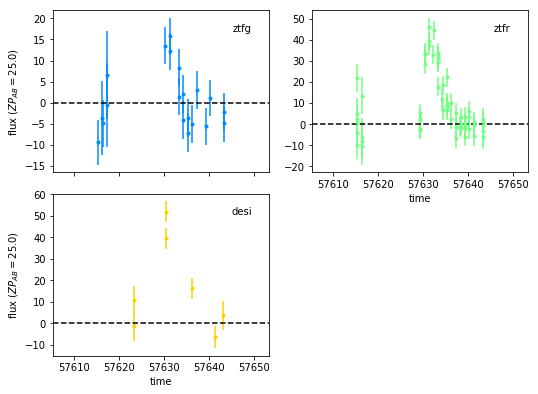

In [14]:
_ = sncosmo.plot_lc(lcs[0])

The two figures below show how early the MNe are detected and at what redshifts. The simulation input parameters of transients that were not detected are also kept, so can check completeness. 

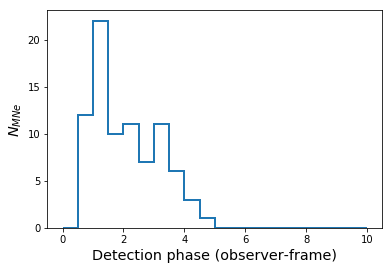

In [15]:
plt.hist(lcs.stats['p_det'], lw=2, histtype='step', range=(0,10), bins=20)
plt.xlabel('Detection phase (observer-frame)', fontsize='x-large')
_ = plt.ylabel(r'$N_{MNe}$', fontsize='x-large')

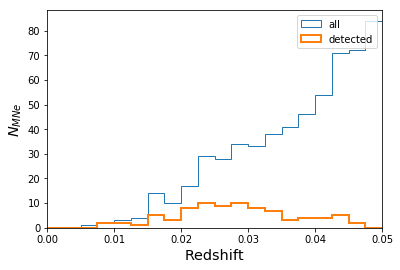

In [16]:
plt.hist(lcs.meta_full['z'], lw=1, histtype='step', range=(0,0.05), bins=20, label='all')
plt.hist(lcs.meta['z'], lw=2, histtype='step', range=(0,0.05), bins=20, label='detected')
plt.xlabel('Redshift', fontsize='x-large')
plt.ylabel(r'$N_{MNe}$', fontsize='x-large')
plt.xlim((0, 0.05))
plt.legend()